In [1]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out

In [4]:
import requests
import json

def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [5]:
import time
end_time = 1555700340
hrs = 24
start_time = int(end_time - 60*60*hrs)
#start_time = 1555614659
result = run_query_range(Queries["cpu"], start_time, end_time, 60)
hosts = {x[0] for x in result}
response = {}
for host in hosts:
    response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]

In [6]:
values = response[Nodes["k8node"]]

In [31]:
FILE_NAME = 'cpu-util.csv'
with open('cpu-util.csv', 'w') as csvfile:
    csvfile.write("TIME,UTIL\n")
    for x, y in values:
        csvfile.write(str(x) +","+str(y) + "\n")

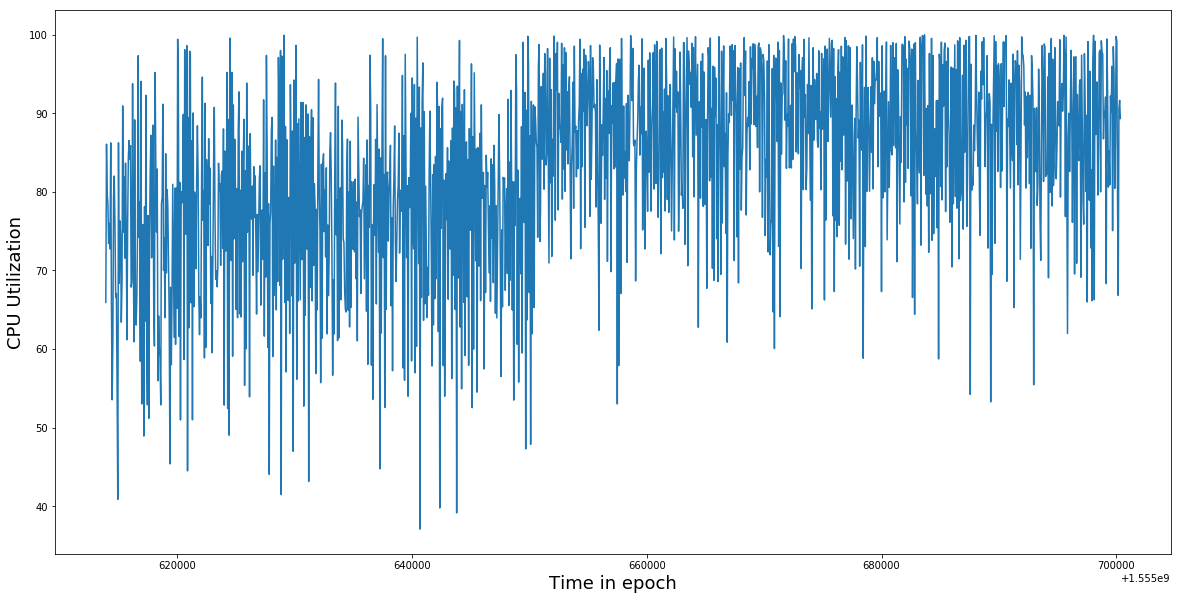

In [7]:
dataframe1 = pd.read_csv('cpu-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [ ]:
import warnings
warnings.filterwarnings('ignore')
aicVal = []
for i in range(1, 50):
    try:
        model_fit = ExponentialSmoothing(y1, seasonal_periods=i, trend='add', 
                                         seasonal='add').fit(use_boxcox=True)
        aicVal.append((i, model_fit.aic))
    except:
        continue

In [21]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1])

In [22]:
aicVal2

[(19, 7012.8647233117),
 (5, 7023.617879656772),
 (7, 7037.008226978511),
 (3, 7042.896520966711),
 (6, 7050.279628690099),
 (4, 7052.850130684078),
 (2, 7054.271630134325),
 (12, 7054.318273028842),
 (8, 7060.0202720181005),
 (17, 7062.664285900919),
 (13, 7063.717880283921),
 (9, 7063.740399138749),
 (10, 7081.665121477584),
 (14, 7105.446836208117),
 (16, 7105.842867218406),
 (15, 7107.463374166072),
 (11, 7111.895912524196),
 (38, 7114.028425503593),
 (26, 7121.060134339917),
 (22, 7138.790196164671),
 (20, 7143.24229545628),
 (24, 7145.479135602403),
 (23, 7149.26700950415),
 (21, 7149.474060015711),
 (32, 7152.908202250904),
 (28, 7157.769820764002),
 (25, 7159.736389169705),
 (37, 7162.785483128774),
 (18, 7163.050282066698),
 (34, 7169.094728701819),
 (31, 7172.8141090201125),
 (27, 7176.879735626037),
 (29, 7181.698279042184),
 (39, 7190.688997424859),
 (33, 7193.10696150098),
 (43, 7194.725266316974),
 (30, 7195.47003238636),
 (35, 7199.667200492263),
 (41, 7205.770039950476)

In [8]:
split_percent = 0.936
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

93
1348


In [120]:
predictions = []
Y_Train = y1[0:train_samples]
model_fit = ExponentialSmoothing(y1, seasonal_periods=19, trend='add', seasonal='add').fit(use_boxcox=True)
predictions.append(model_fit.forecast(93).values)

In [121]:
predictions = predictions[0].reshape(predictions[0].size, 1)

In [137]:
Y_Test = y1[train_samples - 2:-2]
X_Test =  x1[train_samples - 2:-2]

In [138]:
len(Y_Test)

93

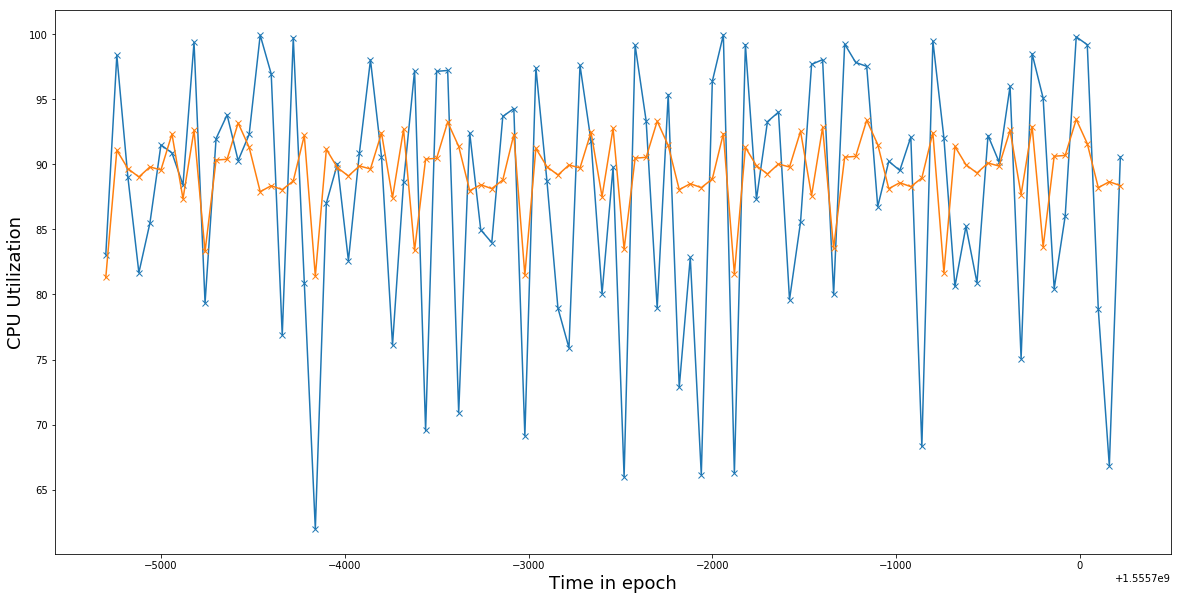

In [142]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, np.array(predictions), {'marker': 'x'})

In [140]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return sqrt(mean_squared_error(y_true, y_pred))

In [141]:
mean_absolute_percentage_error(Y_Test, predictions)

8.973036404117366

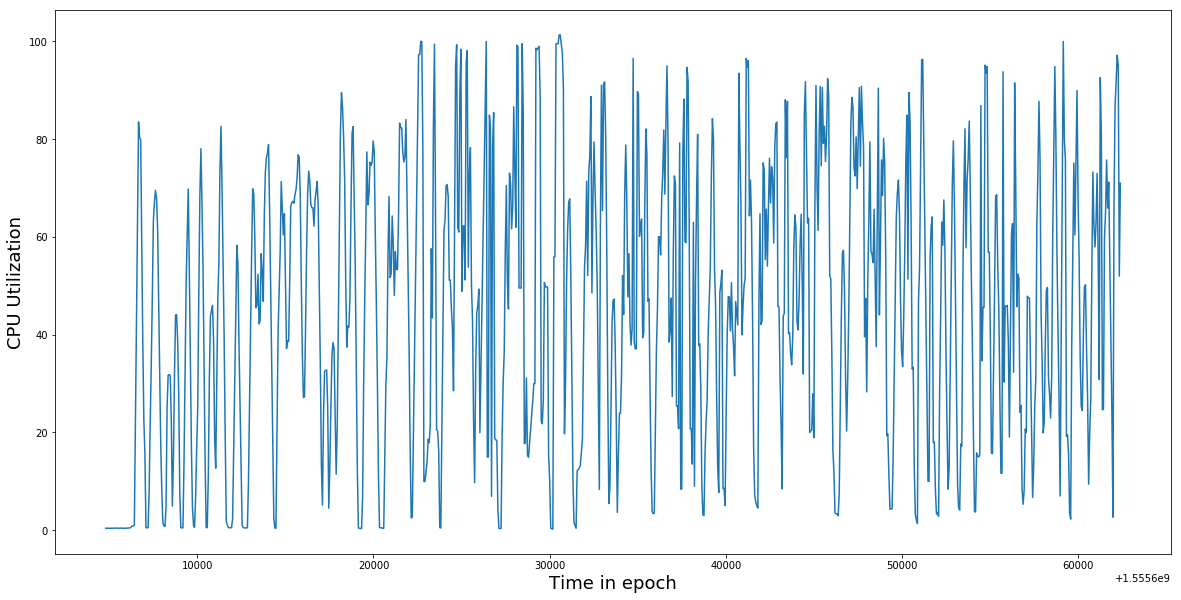

In [143]:
dataframe1 = pd.read_csv('io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [166]:
import warnings
warnings.filterwarnings('ignore')
aicVal = []
for i in range(1, 50):
    try:
        model_fit = ExponentialSmoothing(y1, seasonal_periods=i, trend='add', 
                                         seasonal='add').fit(use_boxcox=True)
        aicVal.append((i, model_fit.aic))
    except:
        continue

In [ ]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1])

In [168]:
split_percent = 0.936
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

60
874


In [183]:
predictions = []
Y_Train = y1[0:train_samples]
model_fit = ExponentialSmoothing(y1, seasonal_periods=7, seasonal='additive').fit(use_boxcox=True)
predictions.append(model_fit.forecast(forecast_time).values)

In [184]:
predictions = predictions[0].reshape(predictions[0].size, 1)

In [185]:
Y_Test = y1[train_samples - 2:-2]
X_Test =  x1[train_samples - 2:-2]

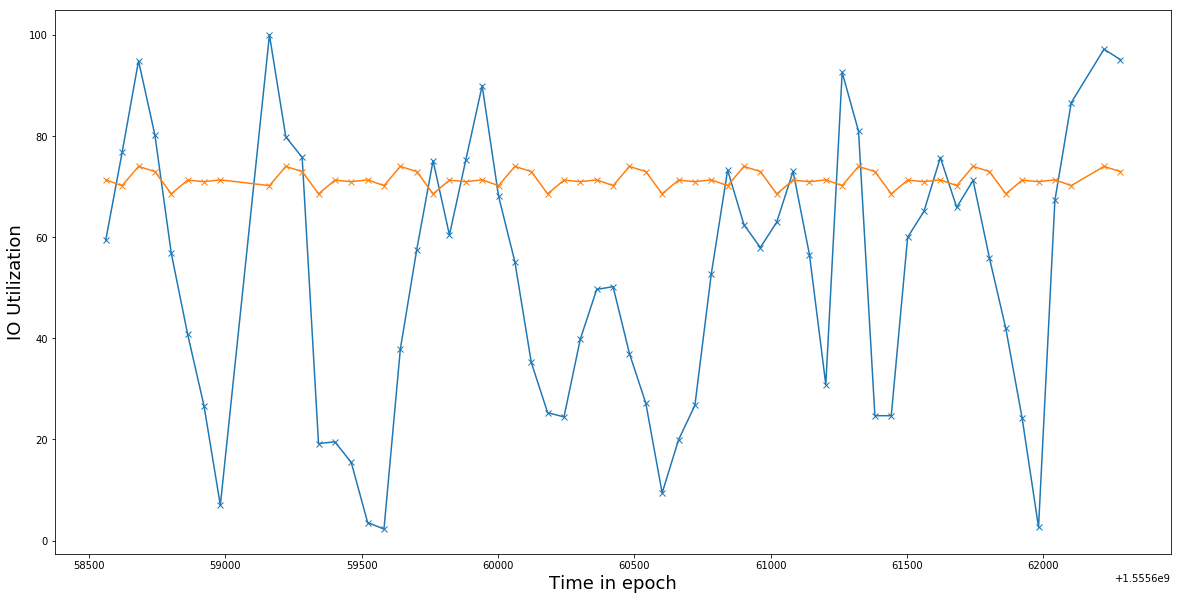

In [186]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, np.array(predictions), {'marker': 'x'})